In [446]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

In [447]:
def generate_samples_and_labels(
    num_samples: int,
    mean: np.ndarray,
    covariance: np.ndarray,
    theta: np.ndarray,
    label_variance: float,
    seed=42,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate samples and corresponding labels from a multivariate Gaussian distribution.

    Args:
        num_samples (int): Number of samples to generate.
        mean (np.ndarray): Mean vector of the multivariate Gaussian distribution.
        covariance (np.ndarray): Covariance matrix of the multivariate Gaussian distribution.
        theta (np.ndarray): Coefficient vector for generating labels.
        label_variance (float): Variance of the Gaussian noise added to the labels.
        seed (int): Seed for the random number generator.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing the generated samples and labels.
    """
    if seed is not None:
        np.random.seed(seed)

    samples = np.random.multivariate_normal(mean, covariance, num_samples)

    labels = np.zeros(num_samples)
    for i, x in enumerate(samples):
        label_mean = np.dot(x, theta)
        labels[i] = np.random.normal(label_mean, label_variance)

    return samples, labels

In [448]:
# Mean vector and covariance matrix for initial sampling
mean = np.array([0, 0])
covariance = np.array([[1, 0], [0, 1]])
num_samples = 20

# Theta vector
theta = np.array([-3, 3])

# Variance for the label distribution
label_variance = 0.1

samples, labels = generate_samples_and_labels(
    num_samples, mean, covariance, theta, label_variance, seed=42
)


In [449]:
# Plotting samples
def plot_samples(samples: np.ndarray, labels: np.ndarray) -> None:
    """
    Plot the samples and labels.

    Args:
        samples (np.ndarray): Array of samples.
        labels (np.ndarray): Array of labels.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(
        samples[:, 0],
        samples[:, 1],
        c=labels,
        cmap="viridis",
        s=100,
        alpha=0.7,
        edgecolor="k",
    )
    plt.colorbar(label="Label value")
    plt.title("2D Gaussian Samples")
    plt.xlabel("X1")
    plt.ylabel("X2")

    plt.grid(True)
    plt.show()

## Posterior distribution

We can compute the posterior distribution using equation (55) and (56) in "PML Lecture Notes for Lectures by Oswin".

In [450]:
def posterior_distribution(covariance, samples):
    """
    Compute the posterior distribution of the weights given the samples.

    Args:
        covariance (np.ndarray): Covariance matrix of the multivariate Gaussian distribution.
        samples (np.ndarray): Samples for which to compute the posterior distribution.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing the mean and covariance of the posterior distribution.
    """

    mean_tmp = (covariance @ samples.T) @ (
        label_variance
        * np.linalg.inv(np.identity(num_samples) + samples @ covariance @ samples.T)
    )
    posterior_mean = mean_tmp @ labels

    posterior_covariance = covariance - mean_tmp @ samples @ covariance

    return posterior_mean, posterior_covariance


In [451]:
# Posterior multivariate normal distribution
posterior_mean, posterior_covariance = posterior_distribution(covariance, samples)
posterior = multivariate_normal(posterior_mean, posterior_covariance)


In [452]:
# Grid ranges
x = np.linspace(-3, 3, 1000)
y = np.linspace(-3, 3, 1000)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
Z = posterior.pdf(pos)


In [453]:
# Contour plot
def plot_contour_and_surface(X, Y, Z):
    cmap = "viridis"
    fig = plt.figure(figsize=(16, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection="3d")

    ff = ax1.contourf(X, Y, Z, levels=50, cmap=cmap)
    ax1.set(
        xlabel="X-axis",
        ylabel="Y-axis",
        title="Contour plot of 2D Multivariate Gaussian Distribution",
    )
    fig.colorbar(ff)

    ax2.plot_surface(X, Y, Z, cmap=cmap)
    ax2.set(
        xlabel="X-axis",
        ylabel="Y-axis",
        zlabel="Probability Density",
        title="3D Surface plot of 2D Multivariate Gaussian Distribution",
    )

    plt.show()

## Posterior predictive distribution

In [454]:
def posterior_predictive(x, cov):
    pp_mean = x @ mean
    pp_cov = x @ cov @ x.T + label_variance
    return pp_mean, pp_cov

https://alpopkes.com/posts/machine_learning/bayesian_linear_regression/
https://gregorygundersen.com/blog/2020/02/04/bayesian-linear-regression/
https://medium.com/@hirok4/plotting-the-distribution-of-parameters-in-bayesian-linear-regression-895fc8eb638f
https://github.com/Hiroaki-K4/PRML/blob/main/linear_regression_model/draw_sequential_bayesian_learning.py#L171

## Plot variance for posterior predictive distribution

In [455]:
def evaluate_quadratic_form(pos, cov, label_variance):
    """
    Evaluate the quadratic form x.T @ cov @ x for each point x in pos.

    Parameters:
    pos (ndarray): An array of shape (..., 2) containing points where the function is evaluated.
    cov (ndarray): A 2x2 covariance matrix.
    label_variance (float): The variance of the label distribution.

    Returns:
    ndarray: An array of values of the quadratic form at each point in pos.
    """
    # Compute the matrix multiplication of pos and cov
    # pos @ cov has the same shape as pos
    cov_times_pos = np.matmul(pos, cov)

    # Element-wise multiplication of pos and cov_times_pos
    # Sum over the last axis to get the scalar value for each point
    values = np.sum(pos * cov_times_pos, axis=-1)

    return values + label_variance

In [456]:
ZZ = evaluate_quadratic_form(pos, posterior_covariance, label_variance)

In [457]:
def plot_variance_surface(X, Y, ZZ):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(X, Y, ZZ, cmap="viridis", edgecolor="none")
    ax.set(
        xlabel="X-axis",
        ylabel="Y-axis",
        title="3D Surface Plot variance for posterior predictive",
    )
    plt.show()

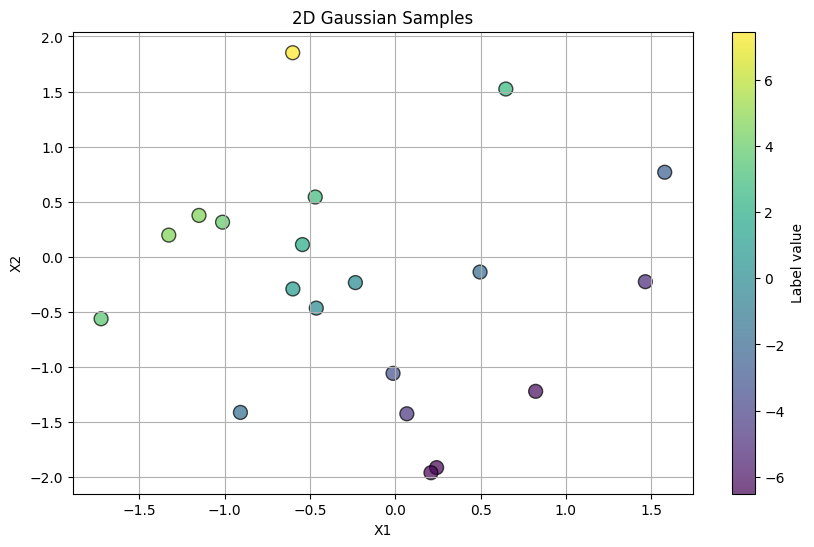

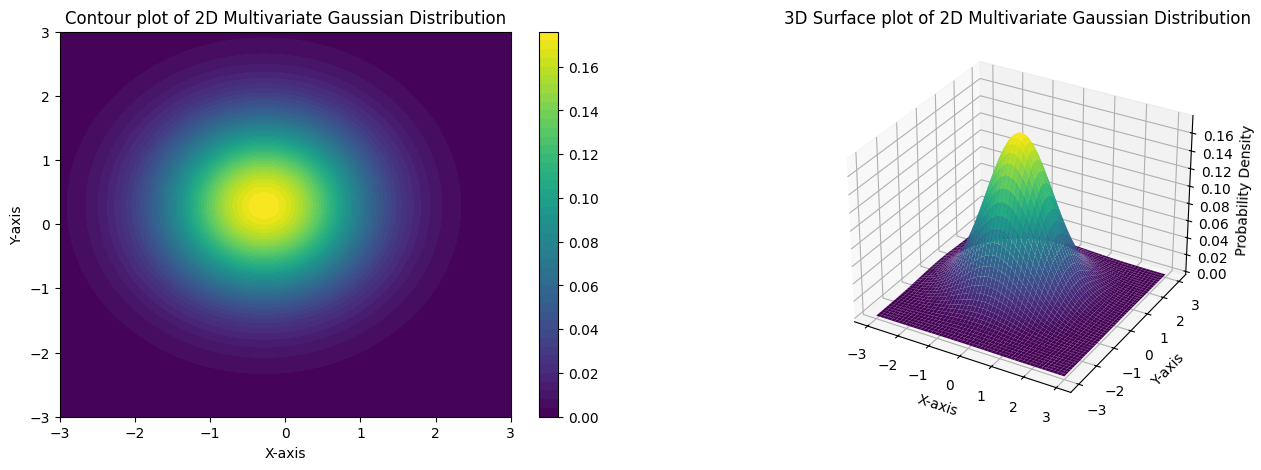

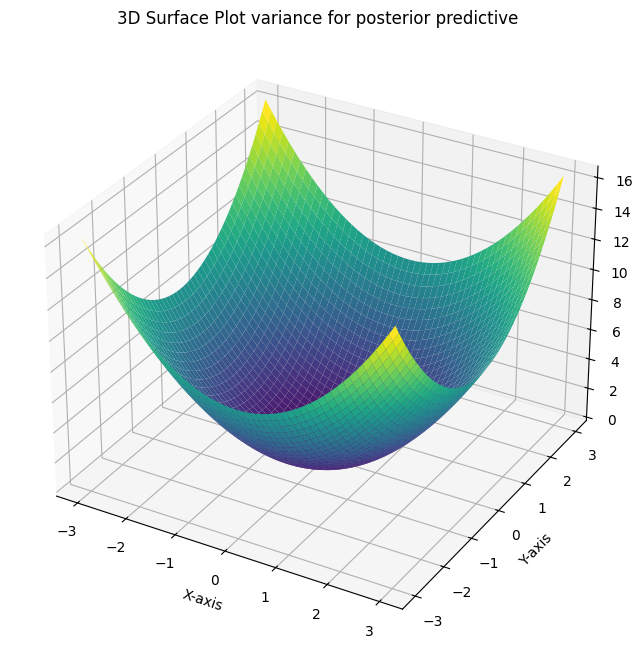

In [458]:
plot_samples(samples, labels)
plot_contour_and_surface(X, Y, Z)
plot_variance_surface(X, Y, ZZ)

In [459]:
covariance2 = np.array([[0.1, 0], [0, 1]])
samples2, labels2 = generate_samples_and_labels(
    num_samples=20,
    mean=mean,
    covariance=covariance2,
    theta=theta,
    label_variance=label_variance,
    seed=42,
)

In [460]:
posterior_mean2, posterior_covariance2 = posterior_distribution(covariance2, samples2)
posterior2 = multivariate_normal(posterior_mean2, posterior_covariance2)
Z2 = posterior2.pdf(pos)

ZZ2 = evaluate_quadratic_form(pos, posterior_covariance2, label_variance)

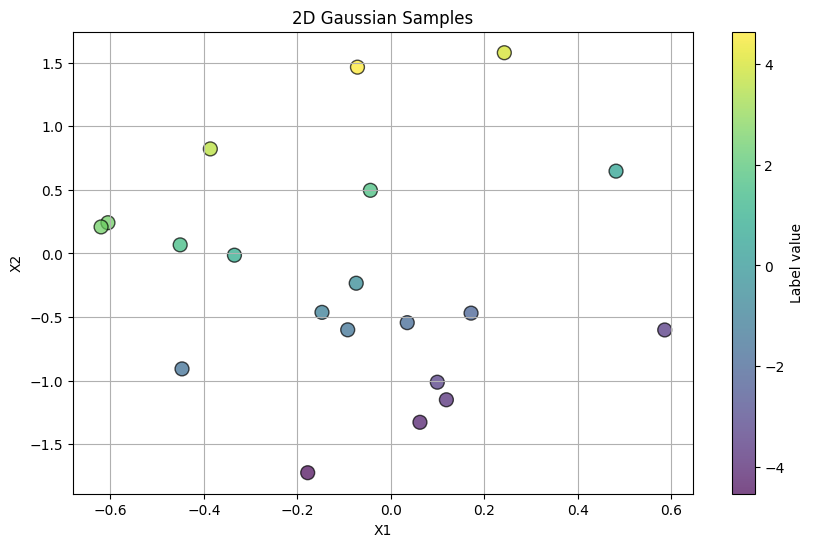

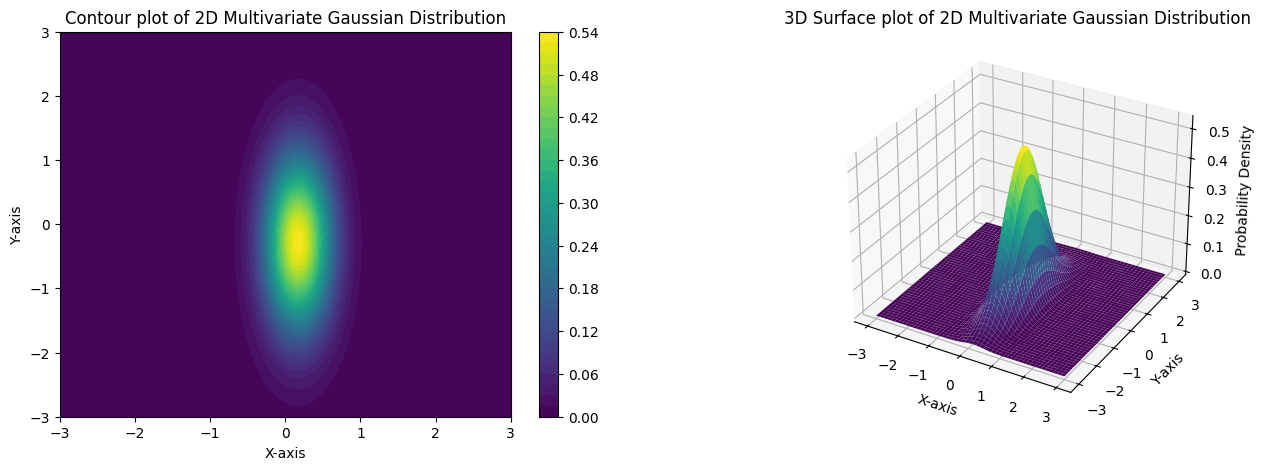

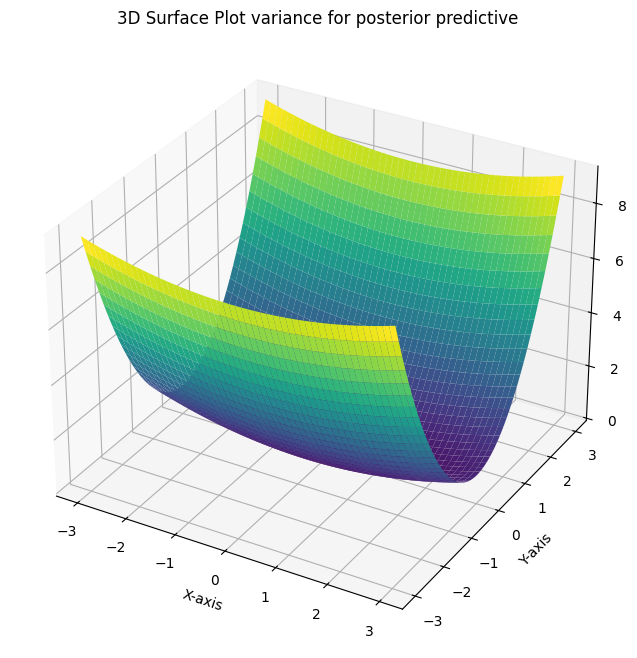

In [461]:
plot_samples(samples2, labels2)
plot_contour_and_surface(X, Y, Z2)
plot_variance_surface(X, Y, ZZ2)